# Computational Social Science Project #2 

**Enter your Name:** Chuxuan Gao

*Semester:* Fall 2024


**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [3]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("data/Diabetes-with-Population-Info-by-County-2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [6]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [8]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:\n', diabetes.dtypes)

data types:
 County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total populatio

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [11]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [13]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())


['No Data']


In [15]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique())


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [20]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!= "No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int)

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!= "No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

In [22]:
#check the results
print('Data types: \n', diabetes[['Diabetes_Number',
                                 'Obesity_Number',
                                 'Physical_Inactivity_Number',
                                 'sex and age_total population_65 years and over_sex ratio (males per 100 females)']].dtypes)

Data types: 
 Diabetes_Number                                                                       int64
Obesity_Number                                                                        int64
Physical_Inactivity_Number                                                            int64
sex and age_total population_65 years and over_sex ratio (males per 100 females)    float64
dtype: object


We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [25]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [28]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

In [30]:
for col in rc_cols:
    if not diabetes[col].between(0, 1).all():
        print(f"{col} contains values out of range (0, 1).")

total housing units contains values out of range (0, 1).


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [34]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1']

In [36]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [39]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

### 2.1 The Target Variable

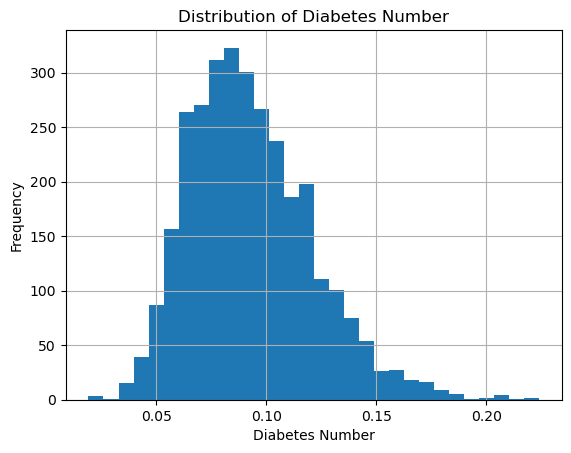

count    3112.000000
mean        0.092857
std         0.028097
min         0.019038
25%         0.072169
50%         0.089291
75%         0.110175
max         0.224208
Name: Diabetes_Number, dtype: float64


In [43]:
# distribution 
diabetes['Diabetes_Number'].hist(bins=30)
plt.title('Distribution of Diabetes Number')
plt.xlabel('Diabetes Number')
plt.ylabel('Frequency')
plt.show()
print(diabetes['Diabetes_Number'].describe())

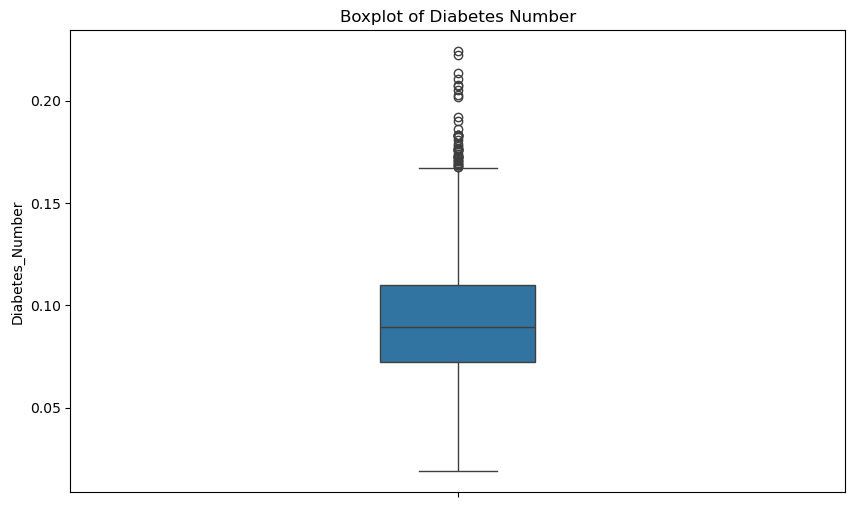

In [45]:
#boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=diabetes, y='Diabetes_Number', width=0.2)
plt.title('Boxplot of Diabetes Number')
plt.show()

The histogram indicates that most counties have a relatively low diabetes ratio, with a mean around 0.093. This suggests that, on average, about 9.3% of individuals per county are affected by diabetes, though there are counties with considerably higher ratios, as evidenced by the outliers in the boxplot.
These outliers could represent counties with disproportionately high diabetes rates, possibly due to factors like socioeconomic conditions, healthcare access, lifestyle differences, or regional dietary habits.

### 2.2 Relationship between Target and Features

In [49]:
#correlations
numeric_diabetes = diabetes.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_diabetes.corr()
correlation_with_diabetes = correlation_matrix['Diabetes_Number'].drop('Diabetes_Number')
correlation_sorted = correlation_with_diabetes.reindex(correlation_with_diabetes.abs().sort_values(ascending=False).index)
print(correlation_sorted)

Physical_Inactivity_Number                                                                                                                              0.591118
Obesity_Number                                                                                                                                          0.549577
hispanic or latino and race_total population_not hispanic or latino_black or african american alone                                                     0.371810
race_total population_one race_black or african american                                                                                                0.369464
race alone or in combination with one or more other races_total population_black or african american                                                    0.365546
race_total population_two or more races_white and asian                                                                                                -0.287866
citizen -  voting age population_c

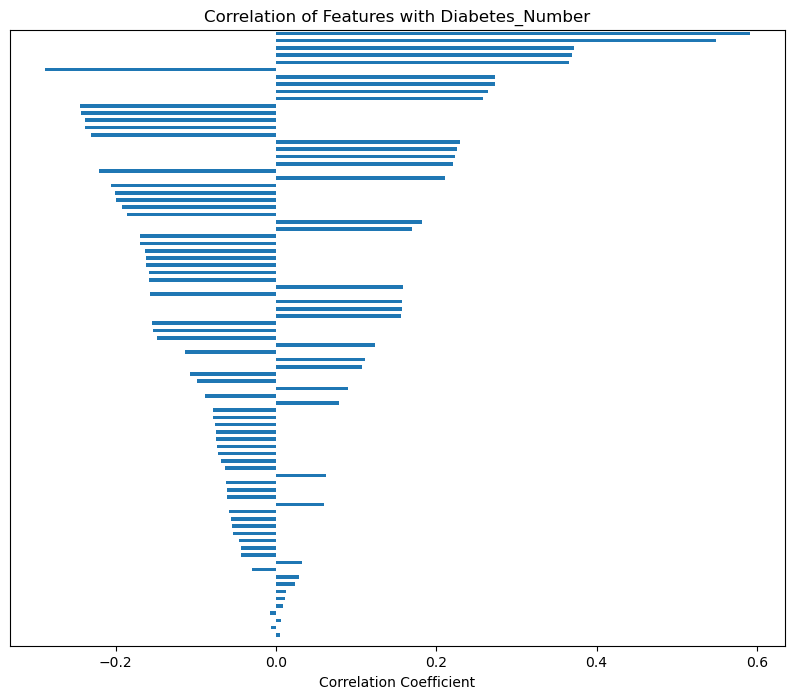

In [51]:
plt.figure(figsize=(10, 8))
correlation_sorted.plot(kind='barh', legend=False)
plt.title('Correlation of Features with Diabetes_Number')
plt.xlabel('Correlation Coefficient')
plt.yticks([]) 
plt.gca().invert_yaxis()
plt.show()

The correlation analysis reveals that physical inactivity and obesity are the strongest predictors of diabetes prevalence across U.S. counties, with correlation coefficients of 0.59 and 0.55, respectively. This suggests that counties with higher rates of physical inactivity and obesity also have higher diabetes ratios, reflecting well-known risk factors for diabetes. Obesity and Physical inactivity seem to be very strong predictors.
Additionally, demographic factors, including certain racial and ethnic group proportions, also show moderate correlations with diabetes prevalence. Factors associated with certain racial and ethnic identity, e.g., socioeconomic status, genetic predisposition, and dietary composition, are likely interwoven, creating cumulative risks that result in higher diabetes prevalence in certain racial and ethnic communities.

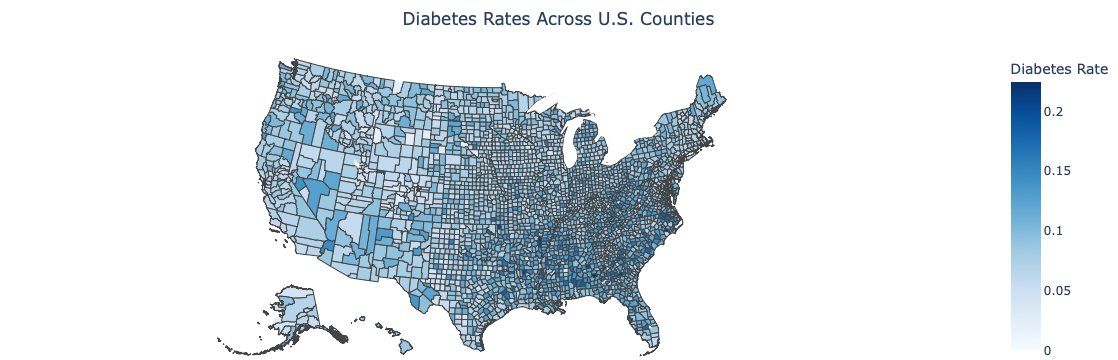

In [54]:
# b.categorical variables
# County
import plotly.express as px
diabetes['CountyFIPS'] = diabetes['CountyFIPS'].astype(str).str.zfill(5)
diabetes['GEO_ID'] = '0500000US' + diabetes['CountyFIPS']

fig = px.choropleth(
    diabetes,
    geojson='https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json',
    locations='GEO_ID',
    featureidkey='properties.GEO_ID',
    color='Diabetes_Number',
    color_continuous_scale='Blues',
    scope='usa',
    labels={'Diabetes_Number': 'Diabetes Rate'},
    hover_name='County',
    hover_data=['State', 'Diabetes_Number'],
    range_color=(0, diabetes['Diabetes_Number'].max()))

fig.update_layout(
    title_text='Diabetes Rates Across U.S. Counties',
    title_x=0.5,
    margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

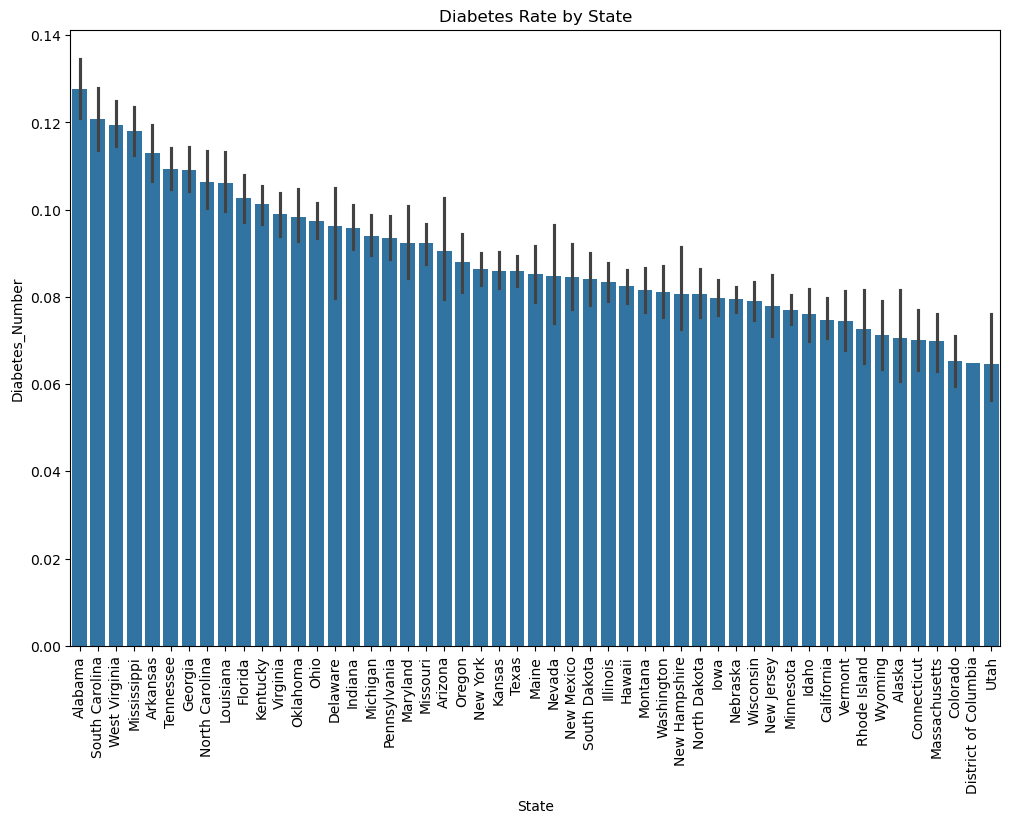

In [56]:
#State
state_data = diabetes.groupby('State', as_index=False)['Diabetes_Number'].mean().sort_values(by='Diabetes_Number', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data = diabetes, x = "State", y = "Diabetes_Number", order=state_data['State'])
plt.title('Diabetes Rate by State')
plt.xticks(rotation=90)
plt.show()

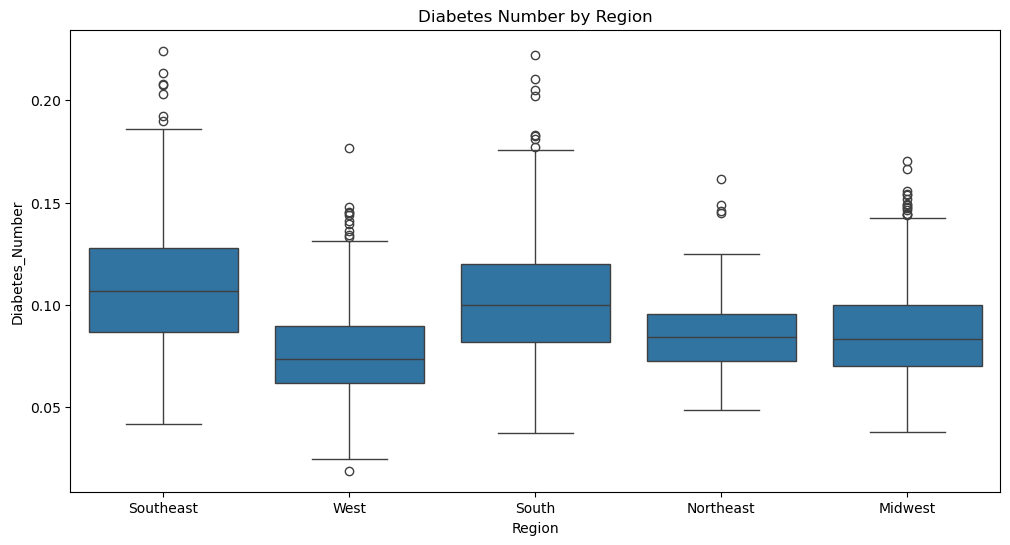

In [58]:
# Region
plt.figure(figsize=(12, 6))
sns.boxplot(data=diabetes, x='Region', y='Diabetes_Number')
plt.title('Diabetes Number by Region')
plt.show()

The geographical distribution of diabetes rates across U.S. shows that the Southeast and parts of the South have some of the highest diabetes prevalence rates. This pattern might implies correlative patterns among features. For example, physical inactivity and obesity are highly correlated with diabetes prevalence. The Southeast, a region known to have higher rates of obesity and physical inactivity, shows a higher concentration of counties with elevated diabetes ratios. Additionally, the socioeconomic and demographic characteristics, such as a higher proportion of certain racial and ethnic groups that face economic and healthcare access challenges, could further explain the higher diabetes rates observed in these areas. 

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [64]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True,
                               dtype = int) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State','GEO_ID'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0      01001         0.093804        0.244366                    0.226902   
1      01003         0.080281        0.233255                    0.192324   
2      01005         0.131875        0.310643                    0.210651   
3      01007         0.105251        0.290052                    0.258667   
4      01009         0.108977        0.246804                    0.249198   
5      01011         0.224208        0.353748                    0.321967   
6      01013         0.145318        0.349513                    0.300974   
7      01015         0.127648        0.298580                    0.234140   
8      01017         0.141518        0.324425                    0.220570   
9      01019         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.2057

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

#### 3.2.1 Partition Data

In [69]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean.Diabetes_Number

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number','race alone or in combination with one or more other races_total population'],
                  axis = 1)

#### 3.2.2 Feature Selection before Training

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

First, I drop 'CountyFIPS' because it is an identifier for each datapoint. Identifier variables are unique to each record and do not contribute meaningful patterns for the models to learn, potentially introducing noise or causing overfitting without enhancing performance.

In [74]:
#
# Feature selection
#-----------
X = X.drop('CountyFIPS', axis = 1)

Second, I check any linear combination in features. Based on the feature names, I suspect that some demographic ratio features might be linear combinations of other features, which could lead to multicollinearity. The OLS regression model is sensitive to this issue. For instance, the sum of “race_total population_one race” and “race_total population_two or more races” always equals 1.

In [77]:
is_perfectly_dependent = np.allclose(diabetes['race_total population_one race'] + diabetes['race_total population_two or more races'], 1)

print("Are they perfectly linearly dependent?", is_perfectly_dependent)

Are they perfectly linearly dependent? True


Similarly, the proportions of each race might also be the sum of various subcategories. I write a function to check for this issue. The results are not consistent, but based on the naming logic, it might be reasonable to assume this issue exists. Take 'race_total population_one race_american indian and alaska native', 'race_total population_one race_asian', and 'race_total population_one race_native hawaiian and other pacific islander' for examples:

In [80]:
def check_linear_combination(df, target_col, source_cols, tolerance=1e-10):
   
    A = df[source_cols].values 
    b = df[target_col].values  
    
    try:
        coeffs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
       
        if residuals.size == 0:  
            residuals = np.array([0])
        
        if np.all(residuals < tolerance):
            print(f"{target_col} IS a linear combination of {source_cols}")
            print("Linear combination coefficients:")
            for col, coeff in zip(source_cols, coeffs):
                print(f"{col}: {coeff}")
            return True
        else:
            print(f"{target_col} IS NOT a linear combination of {source_cols}")
            return False
        
    except np.linalg.LinAlgError:
        print("Matrix is singular or not invertible, cannot find a linear combination.")
        return False


check_linear_combination(diabetes,
                         target_col='race_total population_one race_american indian and alaska native', 
                         source_cols=['race_total population_one race_american indian and alaska native_cherokee tribal grouping',
                                      'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
                                     'race_total population_one race_american indian and alaska native_navajo tribal grouping',
                                     'race_total population_one race_american indian and alaska native_sioux tribal grouping'])

race_total population_one race_american indian and alaska native IS NOT a linear combination of ['race_total population_one race_american indian and alaska native_cherokee tribal grouping', 'race_total population_one race_american indian and alaska native_chippewa tribal grouping', 'race_total population_one race_american indian and alaska native_navajo tribal grouping', 'race_total population_one race_american indian and alaska native_sioux tribal grouping']


False

In [82]:
check_linear_combination(diabetes,
                         target_col='race_total population_one race_asian', 
                         source_cols=['race_total population_one race_asian_asian indian',
                                      'race_total population_one race_asian_chinese',
                                     'race_total population_one race_asian_filipino',
                                     'race_total population_one race_asian_japanese',
                                     'race_total population_one race_asian_korean',
                                     'race_total population_one race_asian_vietnamese',
                                     'race_total population_one race_asian_other asian'])

race_total population_one race_asian IS a linear combination of ['race_total population_one race_asian_asian indian', 'race_total population_one race_asian_chinese', 'race_total population_one race_asian_filipino', 'race_total population_one race_asian_japanese', 'race_total population_one race_asian_korean', 'race_total population_one race_asian_vietnamese', 'race_total population_one race_asian_other asian']
Linear combination coefficients:
race_total population_one race_asian_asian indian: 1.0
race_total population_one race_asian_chinese: 0.9999999999999996
race_total population_one race_asian_filipino: 0.9999999999999957
race_total population_one race_asian_japanese: 1.0000000000000042
race_total population_one race_asian_korean: 0.9999999999999989
race_total population_one race_asian_vietnamese: 0.9999999999999994
race_total population_one race_asian_other asian: 0.9999999999999998


True

In [84]:
check_linear_combination(diabetes,
                         target_col='race_total population_one race_native hawaiian and other pacific islander', 
                         source_cols=['race_total population_one race_native hawaiian and other pacific islander_native hawaiian',
                                      'race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro',
                                     'race_total population_one race_native hawaiian and other pacific islander_samoan',
                                     'race_total population_one race_native hawaiian and other pacific islander_other pacific islander'])

race_total population_one race_native hawaiian and other pacific islander IS a linear combination of ['race_total population_one race_native hawaiian and other pacific islander_native hawaiian', 'race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro', 'race_total population_one race_native hawaiian and other pacific islander_samoan', 'race_total population_one race_native hawaiian and other pacific islander_other pacific islander']
Linear combination coefficients:
race_total population_one race_native hawaiian and other pacific islander_native hawaiian: 1.0000000000000022
race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro: 0.9999999999999996
race_total population_one race_native hawaiian and other pacific islander_samoan: 0.9999999999999968
race_total population_one race_native hawaiian and other pacific islander_other pacific islander: 1.0000000000000009


True

There is also an issue of collinearity among other features.

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"]

if high_vif_features.empty:
    print("No issue of collinearity.")
else:
    print("Collinearity features:\n", high_vif_features)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



Collinearity features:
 2     sex and age_total population_65 years and over...
4                        race_total population_one race
5               race_total population_two or more races
6                  race_total population_one race_white
7     race_total population_one race_black or africa...
8     race_total population_one race_american indian...
13                 race_total population_one race_asian
14    race_total population_one race_asian_asian indian
15         race_total population_one race_asian_chinese
16        race_total population_one race_asian_filipino
17        race_total population_one race_asian_japanese
18          race_total population_one race_asian_korean
19      race_total population_one race_asian_vietnamese
20     race_total population_one race_asian_other asian
21    race_total population_one race_native hawaiian...
22    race_total population_one race_native hawaiian...
23    race_total population_one race_native hawaiian...
24    race_total populat

However, I am setting this issue aside for now because I plan to train models with regularization techniques. To ensure a fair evaluation, I will first use all features to train “naive” models. The OLS regression model is most affected by multicollinearity, so during preliminary model refinement, I will perform further feature selection specifically for the OLS model.

Finally, from the EDA, I observed that the target variable, diabetes_numbers, has a heavy right tail. Domain knowledge could be valuable in determining whether these outliers carry meaningful information. I plan to assess the impact of these outliers when retraining the best model.

In [91]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size = 0.80,      # specify proportional split for training
                                                    test_size = 0.20)       # specify proportional split for test

In [93]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,
                                                             y_train,
                                                             train_size = 0.75,
                                                             test_size = 0.25)

In [95]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_train.select_dtypes(include=['number']).loc[:, X_train.nunique() > 2])


X_train[columns] = scaler.fit_transform(X_train[columns])
X_validate[columns] = scaler.transform(X_validate[columns])
X_test[columns] = scaler.transform(X_test[columns])

**Note:** I made minor adjustments to the code above due to concerns about data leakage. I suspect that fit_transform() should not be used to standardize the validation and test sets; instead, these sets should be standardized using the scaler fitted on the training set.

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**   

**OLS Regression**  
OLS regression seeks to find the line that minimizes the sum of the squared residuals between the predicted and actual values. It calculates coefficients for each feature that minimize the error between predicted and observed outcomes. 
Assumptions:(1)Linearity: The relationship between the independent variables and the target is linear. (2)Homoscedasticity: The variance of residuals is constant across all levels of the independent variables. (3)Independence: Observations are independent. (4)Normality: The residuals (errors) are normally distributed. (5)No multicollinearity: Predictors should not be highly correlated with each other.
OLS model is easy to interpret and implement, but its assumptions are difficult to meet in real-world data. 
OLS represents the foundational approach of traditional social science, so I use OLS here as a baseline model.


**Ridge Regression**
Ridge regression is an extension of OLS that adds an L2 penalty (squared sum of coefficients) to the cost function. This penalizes large coefficients, shrinking them toward zero but never fully eliminating any feature.
Assumptions: Same as OLS regression.
Ridge model reduces overfitting by penalizing large coefficients, making it useful in high-dimensional settings. Ridge model handles multicollinearity better than OLS by shrinking correlated predictor coefficients. But It can still retain many "poor" predictors as it does not eliminate features completely.
The Ridge model could be a suitable choice here, given the significant multicollinearity issues observed.


**LASSO Regression**
LASSO regression adds an L1 penalty (absolute sum of coefficients) to the cost function. This penalty encourages sparsity, driving some coefficients to zero and effectively performing feature selection.
Assumptions: Same as OLS, although it can be more flexible when assumptions are slightly violated.
By driving some coefficient to zero, LASSO performs feature selection effectively to reduce the number of predictors, which can simplify the model and avoid overfitting. But LASSO can be unstable when predictors are highly correlated, as it arbitrarily selects one and drops others.
Like the Ridge model, LASSO performs better when the assumptions for OLS are not met. Given the high correlation among some features, LASSO might not perform as well, but I’d like to examine how it differs from Ridge regression.


**Elastic Net**
Elastic Net combines the L1 and L2 penalties of LASSO and Ridge, allowing it to simultaneously shrink coefficients and select features. This balance of penalties is controlled by a mixing parameter, alpha.
Assumptions: Similar to those of OLS but more adaptable when assumptions are mildly violated.
Elastic Net allows both feature selection (L1) and shrinkage (L2), making it robust in cases with multicollinearity or when many features are irrelevant. Elastic Net is useful when there are many correlated features since it can retain groups of correlated variables instead of discarding them entirely (like LASSO). But Elastic Net has high model complexity and difficult to interpret.
Elastic Net combines the strengths of both Ridge and LASSO, making it advantageous in handling multicollinearity while also performing feature selection.


**KNN Regression**
KNN regression is a non-parametric method that predicts the target for a given observation based on the average of the target values of its k nearest neighbors in feature space. Proximity is determined by a distance metric. 
Assumptions: KNN assumes that similar observations (neighbors) have similar outcomes.
KNN makes no strong assumptions about data distribution, but it can perform poorly on high-dimensional data due to the curse of dimensionality.
KNN regression offers an alternative approach for predicting the target variable. From the geographical distribution of diabetes numbers in EDA, neighboring regions exhibit a certain degree of similarity, suggesting that KNN has the potential to perform well in this context.


### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  OLS

In [103]:
#
# Model 1 training
#-----------

from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train,y_train)

#### Model 2:  Ridge Regression

In [106]:
#
# Model 2 training
#-----------

ridge_reg = Ridge()                             
ridge_model = ridge_reg.fit(X_train, y_train)

#### Model 3:  LASSO Regression

In [109]:
#
# Model 3 training
#-----------

lasso_reg = Lasso(tol=1e-5, max_iter=10000)
lasso_model = lasso_reg.fit(X_train, y_train)

#### Model 4:  Elastic Net

In [112]:
elastic_net = ElasticNet()
elastic_model = elastic_net.fit(X_train, y_train)

#### Model 5:  KNN

In [115]:
knn_reg = KNeighborsRegressor()
knn_model = knn_reg.fit(X_train, y_train)

#### Evaluation Naive Models

In [118]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_models(model_names, model_instances, X_train, y_train, X_validate, y_validate):
    results = []
    for model_name, model_instance in zip(model_names, model_instances):
        
        y_train_pred = model_instance.predict(X_train)
        y_val_pred = model_instance.predict(X_validate)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_validate, y_val_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_validate, y_val_pred)
        
        results.append({
            'Model': model_name,
            'Train RMSE': train_rmse,
            'Validation RMSE': val_rmse,
            'Train R^2': train_r2,
            'Validation R^2': val_r2
        })
        
        plt.figure(figsize=(6, 4))
        plt.scatter(y_validate, y_val_pred, alpha=0.5)
        plt.title(f'{model_name} Model: Actual vs Predicted')
        plt.xlabel('Actual values')
        plt.ylabel('Predicted values')
        plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df

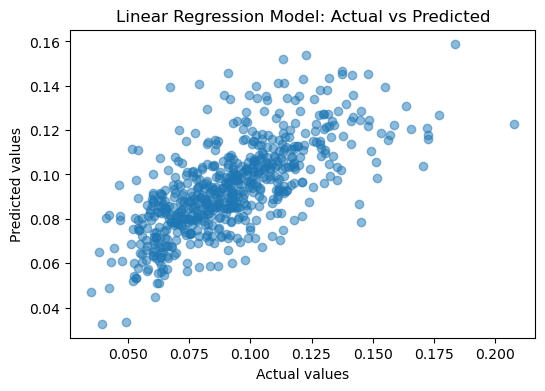

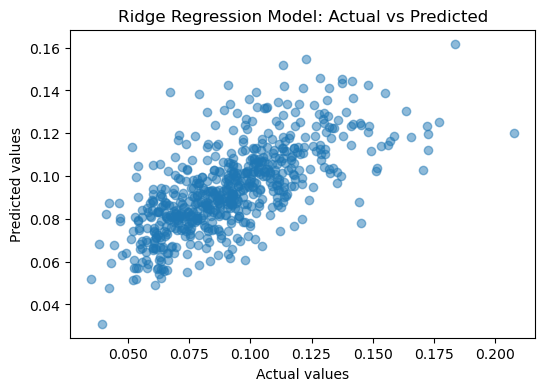

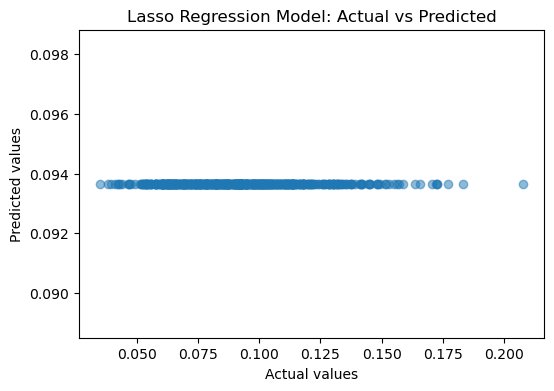

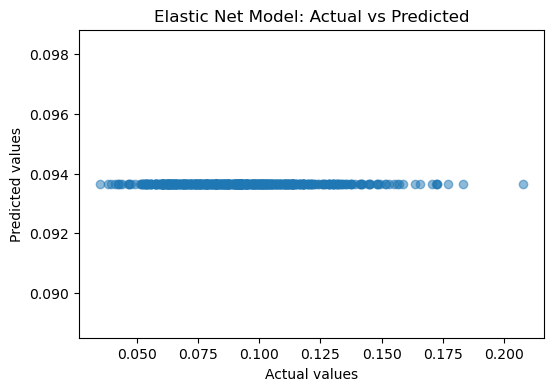

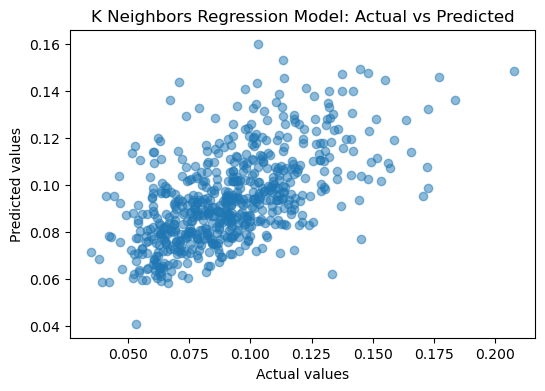

Model  Train RMSE  Validation RMSE  Train R^2  \
0       Linear Regression    0.019718         0.019322   0.534283   
1        Ridge Regression    0.019590         0.019325   0.540304   
2        Lasso Regression    0.028893         0.026106   0.000000   
3             Elastic Net    0.028893         0.026106   0.000000   
4  K Neighbors Regression    0.017894         0.021619   0.616440   

   Validation R^2  
0        0.448829  
1        0.448668  
2       -0.006166  
3       -0.006166  
4        0.309972

In [120]:
model_name = ['Linear Regression', 
               'Ridge Regression', 
               'Lasso Regression',
               'Elastic Net',
               'K Neighbors Regression']
model_instance = [lin_model,
                   ridge_model,
                   lasso_model,
                   elastic_model,
                   knn_model]
results_df = evaluate_models(model_name, model_instance, X_train, y_train, X_validate, y_validate)
results_df

The LASSO Regression and Elastic Net models perform very poorly with near-zero R^2 values on the training sets and negative R^2 values on the validation sets. This is due to inappropriate hyperparameter settings. The models might be overly penalizing the coefficients
Therefore, I will tune hyperparameters before choosing the best model.

#### Preliminary Model Refinement

In [142]:
# OLS Regression

columns_to_drop = ['race_total population_one race', 
                   'race_total population_two or more races',
            'race_total population_one race_american indian and alaska native',
            'race_total population_one race_asian',
            'race_total population_one race_native hawaiian and other pacific islander',
            'race alone or in combination with one or more other races_total population_white',
            'hispanic or latino and race_total population_hispanic or latino (of any race)',
            'citizen -  voting age population_citizen -  18 and over population',
            'sex and age_total population_male',
            'sex and age_total population_under 5 years' ]

X_train_ols = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
X_validate_ols = X_validate.drop(columns=[col for col in columns_to_drop if col in X_validate.columns])
X_test_ols = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])

columns = list(X_train_ols.select_dtypes(include=['number']).loc[:, X_train_ols.nunique() > 2])
X_train_ols[columns] = scaler.fit_transform(X_train_ols[columns])
X_validate_ols[columns] = scaler.transform(X_validate_ols[columns])
X_test_ols[columns] = scaler.transform(X_test_ols[columns])

lin_model_refined = lin_reg.fit(X_train_ols,y_train)

In [144]:
X_train_ols.head()

Obesity_Number  Physical_Inactivity_Number  \
3000       -0.084705                   -1.226239   
2866       -1.587600                   -1.874681   
1090        1.027186                    1.819789   
773         0.737730                    0.443848   
1514        0.716577                    1.312991   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
3000                                          -0.538532                                  
2866                                           0.845408                                  
1090                                          -0.764482                                  
773                                           -0.406728                                  
1514                                           0.788921                                  

      race_total population  race_total population_one race_white  \
3000              -0.242048                              0.084483   
2866              -0.260192                              0.639777   
1090              -0.125683                              0.865293   
773               -0.233461                              0.607632   
1514              -0.255804                              0.168558   

      race_total population_one race_black or african american  \
3000                                           0.039344          
2866                                          -0.620083          
1090                                          -0.570095          
773                                           -0.358729          
1514                                           0.039402          

      race_total population_one race_american indian and alaska native_cherokee tribal grouping  \
3000                                          -0.112913                                           
2866                                          -0.129220                                           
1090                                          -0.111395                                           
773                                           -0.111936                                           
1514                                           0.042402                                           

      race_total population_one race_american indian and alaska native_chippewa tribal grouping  \
3000                                           -0.07355                                           
2866                                           -0.07355                                           
1090                                           -0.07355                                           
773                                            -0.07355                                           
1514                                           -0.07355                                           

      race_total population_one race_american indian and alaska native_navajo tribal grouping  \
3000                                          -0.050943                                         
2866                                          -0.050943                                         
1090                                          -0.050943                                         
773                                           -0.050943                                         
1514                                          -0.050943                                         

      race_total population_one race_american indian and alaska native_sioux tribal grouping  \
3000                                          -0.087378                                        
2866                                          -0.087378                                        
1090                                          -0.061198                                        
773                                           -0.087378                                        
1514                                          -0.077214                                

In [148]:
X_train.head()

Obesity_Number  Physical_Inactivity_Number  \
3000       -0.084705                   -1.226239   
2866       -1.587600                   -1.874681   
1090        1.027186                    1.819789   
773         0.737730                    0.443848   
1514        0.716577                    1.312991   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
3000                                          -0.538532                                  
2866                                           0.845408                                  
1090                                          -0.764482                                  
773                                           -0.406728                                  
1514                                           0.788921                                  

      race_total population  race_total population_one race  \
3000              -0.242048                       -0.495785   
2866              -0.260192                        0.067501   
1090              -0.125683                        0.819381   
773               -0.233461                        0.181640   
1514              -0.255804                       -0.299890   

      race_total population_two or more races  \
3000                                 0.495785   
2866                                -0.067501   
1090                                -0.819381   
773                                 -0.181640   
1514                                 0.299890   

      race_total population_one race_white  \
3000                              0.084483   
2866                              0.639777   
1090                              0.865293   
773                               0.607632   
1514                              0.168558   

      race_total population_one race_black or african american  \
3000                                           0.039344          
2866                                          -0.620083          
1090                                          -0.570095          
773                                           -0.358729          
1514                                           0.039402          

      race_total population_one race_american indian and alaska native  \
3000                                          -0.248544                  
2866                                          -0.094136                  
1090                                          -0.227721                  
773                                           -0.244375                  
1514                                          -0.150640                  

      race_total population_one race_american indian and alaska native_cherokee tribal grouping  \
3000                                          -0.112913                                           
2866                                          -0.129220                                           
1090                                          -0.111395                                           
773                                           -0.111936                                           
1514                                           0.042402                                           

      race_total population_one race_american indian and alaska native_chippewa tribal grouping  \
3000                                           -0.07355                                           
2866                                           -0.07355                                           
1090                                           -0.07355                                           
773                                            -0.07355                                           
1514                                           -0.07355                                           

      race_total population_one race_american indian and alaska native_navajo tribal grouping  \
3000                                          -0.050943                 

In [150]:
# Ridge Regression
param_grid = {'alpha': np.logspace(1, 3, 20),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5)
ridge_grid_reg.fit(X_train, y_train)
best_params = ridge_grid_reg.best_params_
print("Best parameters:", best_params)

Best parameters: {'alpha': 233.57214690901213, 'fit_intercept': True, 'solver': 'lsqr'}


In [151]:
# LASSO Regression
# param_grid = {
     # 'alpha': np.logspace(-6, -2, 20),
     # 'fit_intercept': [True, False],
     # 'selection': ['cyclic', 'random']}

# lasso_grid_reg = GridSearchCV(
    # Lasso(max_iter=50000),
    # param_grid=param_grid,
    # cv=5)

# lasso_grid_reg.fit(X_train, y_train)
# best_params = lasso_grid_reg.best_params_
# print("Best parameters:", best_params)

Given the persistent convergence issues with the LASSO model despite multiple adjustments, it might be  reasonable to give up LASSO model and consider Elastic Net Instead. Since the data lacks inherent sparsity or contains high multicollinearity among features, LASSO may struggle to converge or produce stable results. In such case, Elastic Net provides a more balanced approach by allowing a mix of feature selection and coefficient shrinkage. 

In [153]:
# Elastic Net
param_grid = {'alpha': np.logspace(-2, 3, 20),
              'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]}
elastic_grid = GridSearchCV(elastic_net,
                            param_grid,
                            cv=5)
elastic_grid.fit(X_train, y_train)
best_params = elastic_grid.best_params_
print("Best parameters:", best_params)

Best parameters: {'alpha': 0.03359818286283781, 'l1_ratio': 0.01}


Note: I will further tuning the l1_ratio if Elastic Net is the best model.

In [154]:
# KNN
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
knn_grid = GridSearchCV(knn_reg,
                        param_grid,
                        cv=5)
knn_grid.fit(X_train, y_train)
best_params = knn_grid.best_params_
print("Best parameters:", best_params)

Best parameters: {'n_neighbors': 19, 'p': 2, 'weights': 'distance'}


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

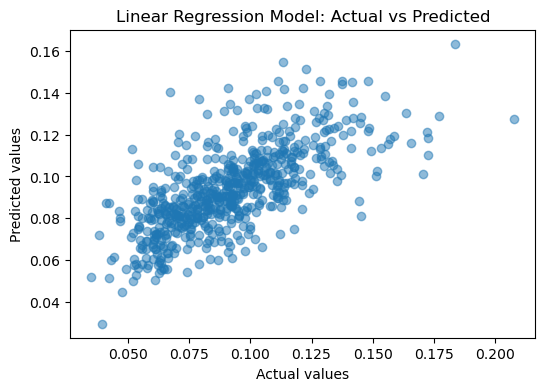

Model  Train RMSE  Validation RMSE  Train R^2  Validation R^2
0  Linear Regression    0.019649         0.019254   0.537545        0.452677

In [157]:
#
# Predict on validation data
#-----------
model_name = ['Linear Regression']
model_instance = [lin_model_refined]
results_df = evaluate_models(model_name, model_instance, X_train_ols, y_train, X_validate_ols, y_validate)
results_df

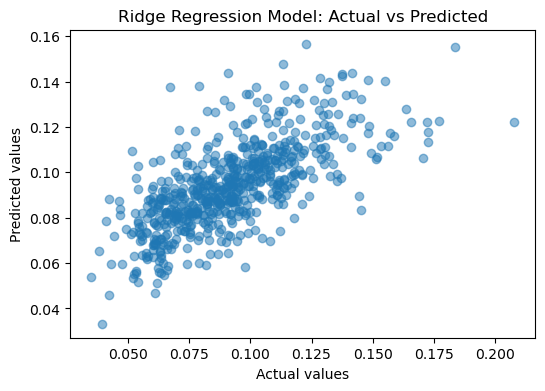

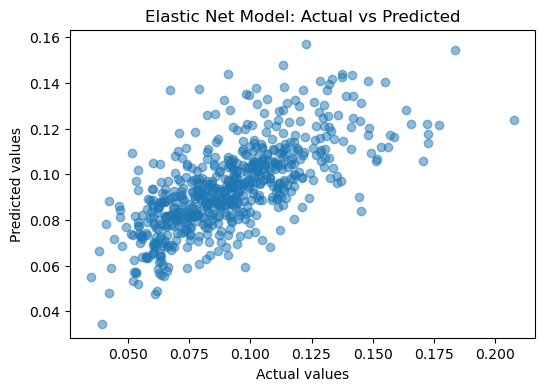

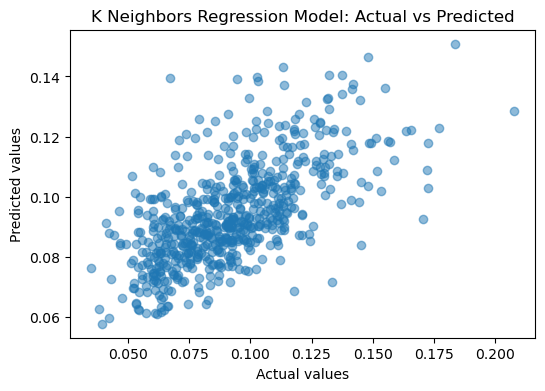

Model    Train RMSE  Validation RMSE  Train R^2  \
0        Ridge Regression  1.981654e-02         0.019205   0.529609   
1             Elastic Net  1.986494e-02         0.019164   0.527308   
2  K Neighbors Regression  8.487130e-09         0.020224   1.000000   

   Validation R^2  
0        0.455468  
1        0.457801  
2        0.396135

In [203]:
model_name = [ 'Ridge Regression', 
               'Elastic Net',
               'K Neighbors Regression']
model_instance = [ ridge_grid_reg.best_estimator_,
                   elastic_grid.best_estimator_,
                   knn_grid.best_estimator_]

results_df = evaluate_models(model_name, model_instance, X_train, y_train, X_validate, y_validate)
results_df

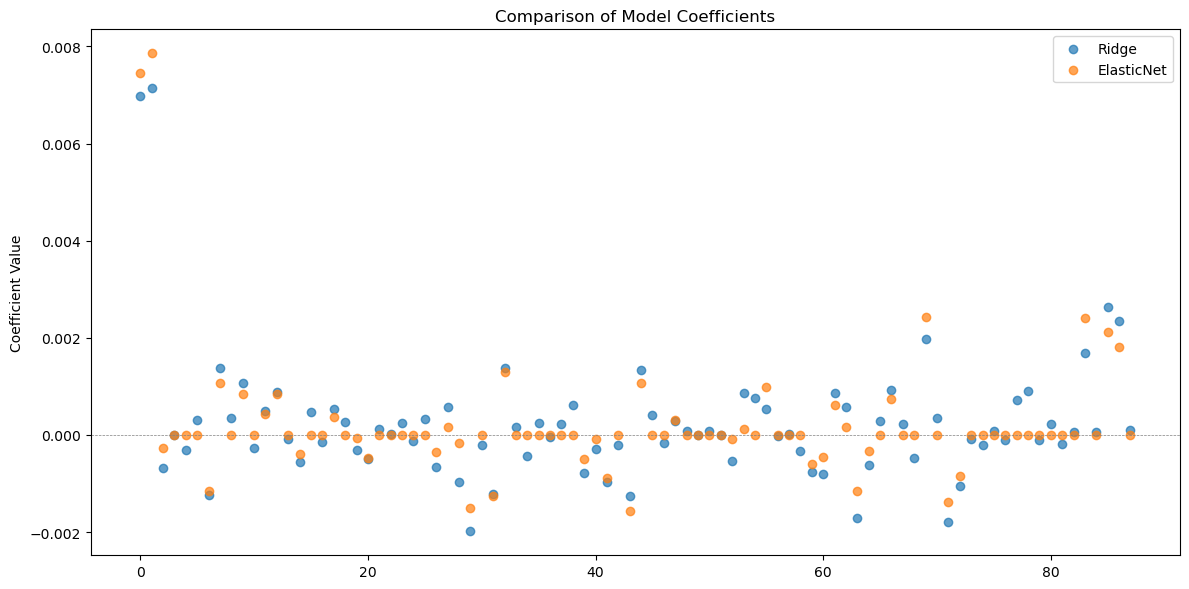

In [169]:
ridge_coef = ridge_grid_reg.best_estimator_.coef_
elastic_net_coef = elastic_grid.best_estimator_.coef_

n_features = len(ridge_coef)
x = np.arange(n_features)

plt.figure(figsize=(12, 6))

plt.scatter(x, ridge_coef, label="Ridge", alpha=0.7)
plt.scatter(x, elastic_net_coef, label="ElasticNet", alpha=0.7)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  
plt.title("Comparison of Model Coefficients")
plt.ylabel("Coefficient Value")
plt.legend()
plt.tight_layout()
plt.show()

**The best model is Elastic Net.**  
Elastic Net’s performance shows that it is neither overfitting nor underfitting significantly. By combining the L1 and L2 penalties, Elastic Net benefits from the feature selection power of LASSO while also shrinking coefficients similarly to Ridge, thus preventing any single feature from dominating the model. Ridge Regression showed similar, though slightly less accurate performance, which is expected as it does not eliminate irrelevant features as effectively as Elastic Net. K Neighbors Regression, while achieving perfect fit on the training data (high variance), performed poorly on the validation set, indicating overfitting. This suggests that K Neighbors Regression has high variance and low bias, making it less suitable for this dataset. Overall, Elastic Net strikes a practical balance in reducing both variance and bias, making it the most generalizable and stable model in this context.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [339]:
# Select out unimportant features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net_coef
})
feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)
print(feature_importance)

                                              Feature  Coefficient
1                          Physical_Inactivity_Number     0.007860
0                                      Obesity_Number     0.007451
69        sex and age_total population_65 to 74 years     0.002433
83  sex and age_total population_65 years and over...     0.002399
85                                       Region_South     0.002124
86                                   Region_Southeast     0.001802
43  hispanic or latino and race_total population_n...    -0.001576
29  race_total population_two or more races_white ...    -0.001505
71     sex and age_total population_85 years and over    -0.001373
32  race alone or in combination with one or more ...     0.001300
31  race alone or in combination with one or more ...    -0.001267
6                race_total population_one race_white    -0.001150
63        sex and age_total population_20 to 24 years    -0.001145
44  hispanic or latino and race_total population_n...     0.00

In [341]:
unimportant_features = feature_importance[feature_importance['Coefficient']==0]['Feature'].tolist()
print(unimportant_features)

['sex and age_total population_35 to 44 years', 'race_total population', 'sex and age_total population_55 to 59 years', 'race_total population_one race_american indian and alaska native', 'sex and age_total population_60 to 64 years', 'sex and age_total population_75 to 84 years', 'Region_Northeast', 'sex and age_total population_18 years and over_male', 'race_total population_two or more races', 'race_total population_one race', 'sex and age_total population_65 years and over_male', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)', 'sex and age_total population_under 18 years', 'sex and age_total population_18 years and over_female', 'sex and age_total population_18 years and over', 'sex and age_total population_21 years and over', 'sex and age_total population_62 years and over', 'sex and age_total population_65 years and over', 'sex and age_total population_16 years and over', 'hispanic or latino and race_total population_not hispanic or latino_two 

In [343]:
threshold = 0.000001
unimportant_features = feature_importance[feature_importance['Coefficient'].abs() < threshold]['Feature'].tolist()
X_reduced = X.drop(columns=unimportant_features)
X_train_reduced = X_train.drop(columns=unimportant_features)
X_validate_reduced = X_validate.drop(columns=unimportant_features)
X_test_reduced = X_test.drop(columns=unimportant_features)

param_grid = {
    'alpha': np.logspace(-2, 3, 20),
    'l1_ratio': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]  # Expanding the range closer to zero
}

elastic_net = ElasticNet(max_iter=10000)
elastic_grid = GridSearchCV(elastic_net, param_grid, cv=5)
elastic_grid.fit(X_train_reduced, y_train)
final_model = elastic_grid.best_estimator_

best_params = elastic_grid.best_params_
print("Updated best parameters:", best_params)

Updated best parameters: {'alpha': 0.11288378916846889, 'l1_ratio': 0.0001}


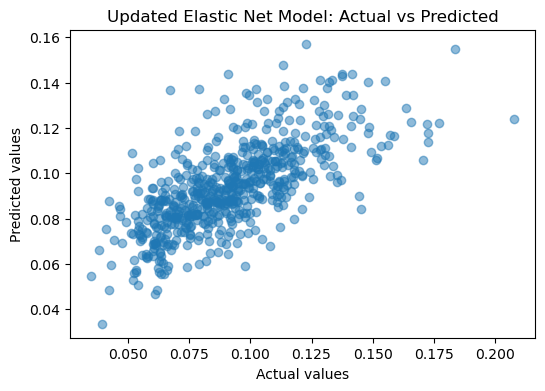

Model  Train RMSE  Validation RMSE  Train R^2  Validation R^2
0  Updated Elastic Net    0.019838         0.019148   0.528575        0.458682

In [352]:
model_name = [ 'Updated Elastic Net']
model_instance = [final_model]
results_df = evaluate_models(model_name, model_instance, X_train_reduced, y_train, X_validate_reduced, y_validate)
results_df

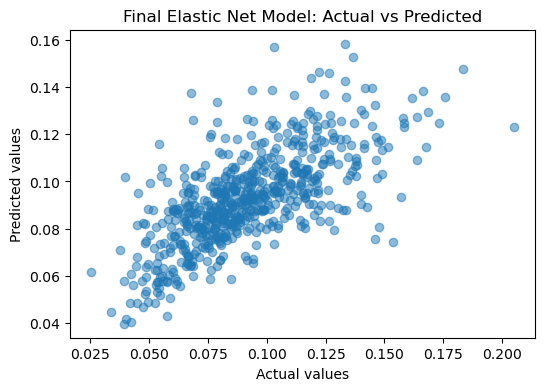

Model  Train RMSE  Validation RMSE  Train R^2  Validation R^2
0  Final Elastic Net    0.019838         0.020272   0.528575        0.459005

In [381]:
#
# Predict using your best model
#-----------

model_name = [ 'Final Elastic Net']
model_instance = [final_model]
results_df = evaluate_models(model_name, model_instance, X_train_reduced, y_train, X_test_reduced, y_test)
results_df

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

Cross-Validation RMSE: [0.03034232 0.0225078  0.02122068 0.02474731 0.02758309]
Mean Cross-Validation MSE: 0.025280239854888958
Standard Deviation of Cross-Validation MSE: 0.0033280106365672


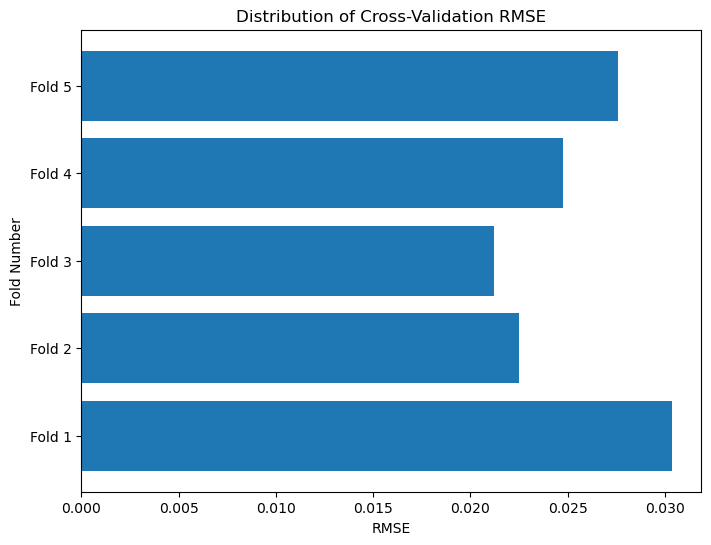

In [383]:
#
# Run cross-validation
#-----------
cv_scores = - cross_val_score(final_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-Validation RMSE:", cv_scores)
print("Mean Cross-Validation MSE:", cv_scores.mean())
print("Standard Deviation of Cross-Validation MSE:", cv_scores.std())

cv_scores = - cross_val_score(final_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
# Plot a horizontal histogram
plt.figure(figsize=(8, 6))
plt.barh(range(len(cv_scores)), cv_scores)
plt.title("Distribution of Cross-Validation RMSE")
plt.xlabel("RMSE")
plt.ylabel("Fold Number")
plt.yticks(range(len(cv_scores)), [f'Fold {i+1}' for i in range(len(cv_scores))])
plt.show()

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

Machine learning models relax the assumption of unbiasedness, which introduces the bias-variance tradeoff in evaluating model performance. In short, “high bias” refers to underfitting, where the model fails to capture enough information from the training data. In contrast, “high variance” refers to overfitting, where the model captures too much noise from the training data and struggles to generalize to unseen data. The expected squared error can be expressed as E[(y - ŷ)^2] = [Bias]^2 + Variance.

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting refers to the phenomenon where a model performs too well on the training set but fails to generalize to unseen data.   
There are two types of errors: (1) training set error, which refers to misclassifying points in the training set, and (2) test set error, which refers to the fraction of misclassified new data. If a model pursues an extremely low level of training set error, it is likely to capture noise and minor variations in the training set. As a result, this model can only perform well on the specific training set, while the test set error becomes high, making the model’s predictions unreliable on unseen data.  
Regularization is a technique used to prevent overfitting by penalizing model complexity. Ridge regression and LASSO (Least Absolute Shrinkage and Selection Operator) are two common methods involving regularization. Ridge regression adds the squared values of the coefficients as a penalty term, while LASSO adds the absolute values of the coefficients. By selecting the most relevant features (LASSO) or shrinking the importance of certain features (both ridge and LASSO), variance is reduced, though this may also result in increased bias

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

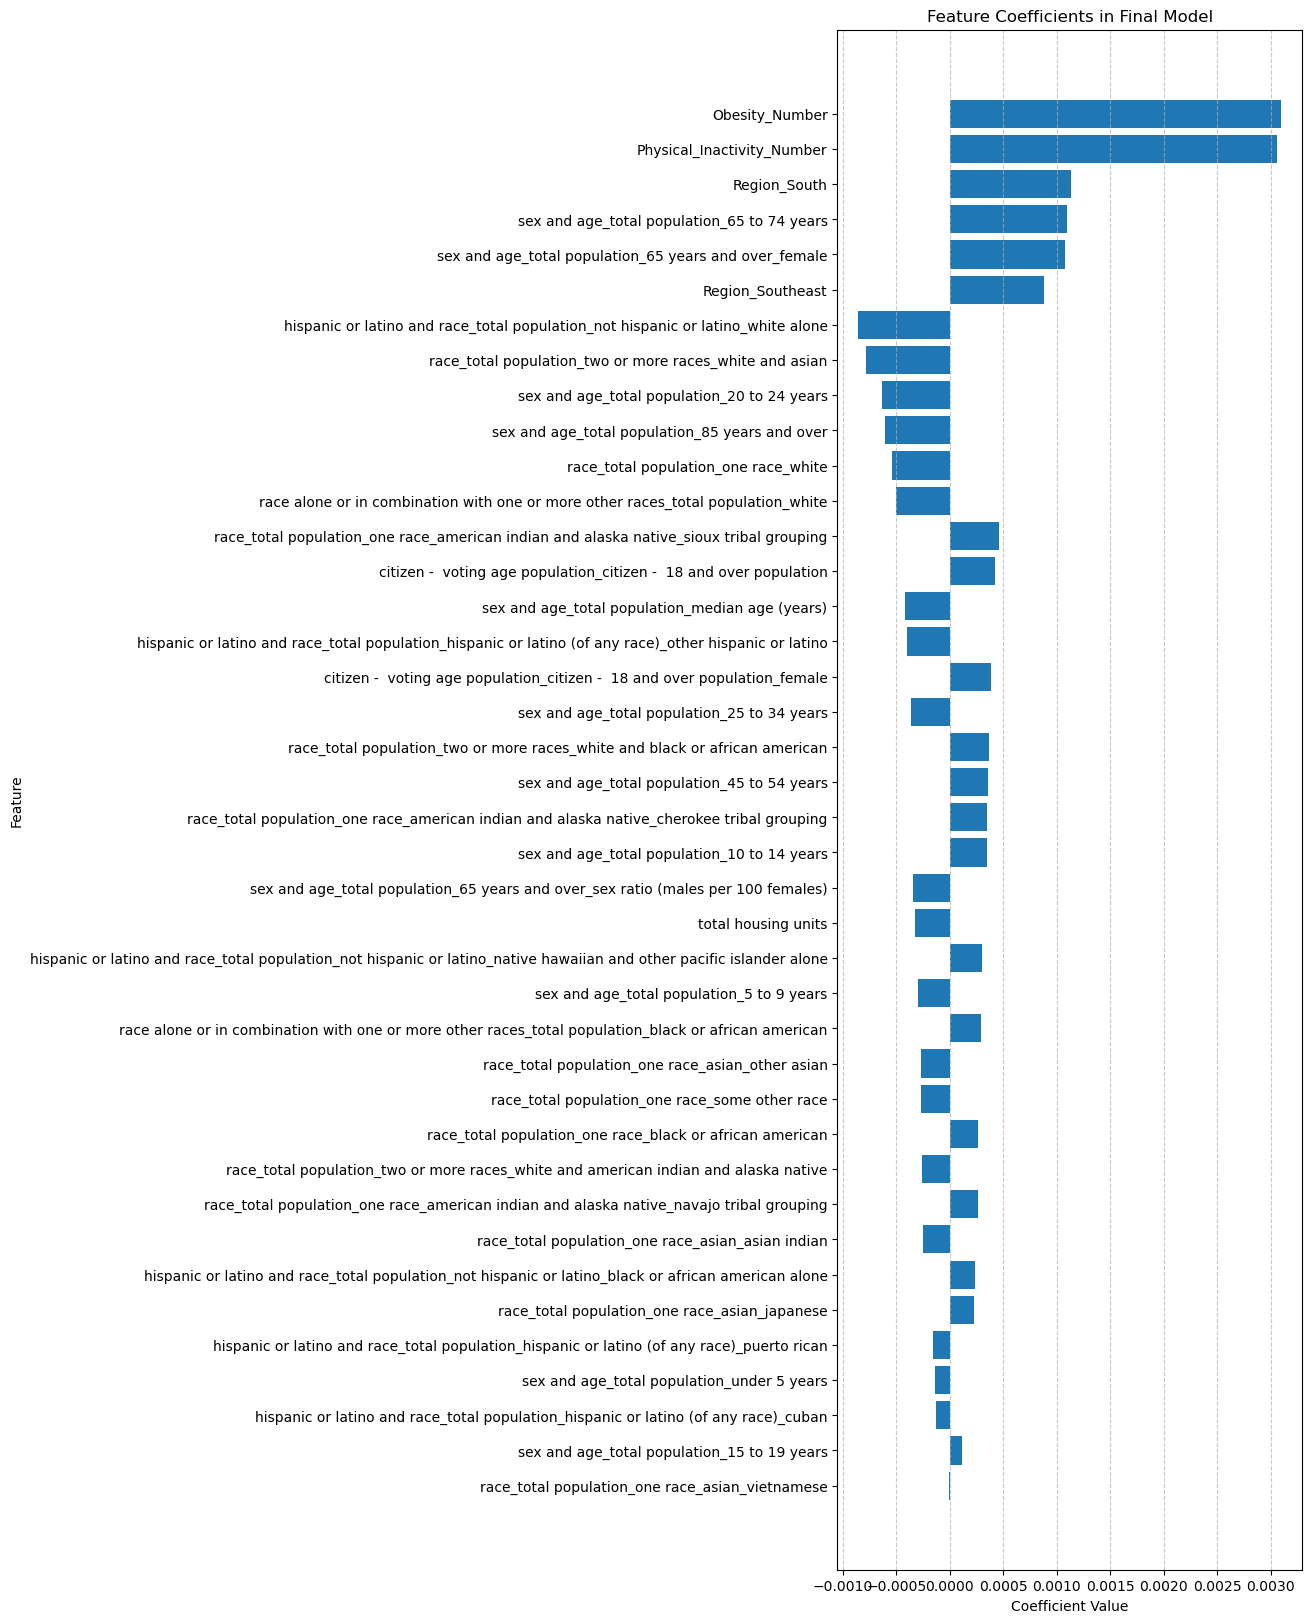

In [390]:
# print coefficient 
coefficients = elastic_grid.best_estimator_.coef_
features = X_reduced.columns

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by = 'Abs_Coefficient', ascending = True)

plt.figure(figsize=(6, 20))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Coefficients in Final Model")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In short, I prioritize counties with high Obesity Numbers and Physical Inactivity Numbers in South or Southeast in the pilot project. Based on the Elastic Net regression model I built, the results indicate that key features significantly influence the model’s predictions, including indicators related to physical inactivity and obesity rates. These health-related variables show the largest coefficients in magnitude, suggesting that regions with higher physical inactivity and obesity may face higher risk factors or associated costs that are pertinent to this study’s objectives. Regional variables, such as those representing the South and Southeast, also exhibit notable coefficients, hinting at possible geographical disparities in outcomes. This suggests that prioritizing counties in these regions could be beneficial for a pilot program focused on health interventions, as they might yield more observable impacts on key health outcomes.  

Race, gender, and age are considered sensitive attributes in machine learning, particularly when it comes to the principle of fairness. In predictive models, these attributes can inadvertently lead to unfair disadvantages for certain groups, as the model may capture patterns influenced by historical or systemic biases. In the diabetes prediction model for this project, attributes like race, gender, and age are likely related to diabetes incidence through both physiological factors and socioeconomic factors, potentially acting as mediating variables. This means they could reflect genuine associations with health outcomes, but also risk amplifying health disparities if not carefully managed.
Using these variables directly in predictions raises ethical questions. Since the model is predicting at a regional level rather than targeting individuals directly, the ethical implications might seem less severe. However, the relationship between these sensitive attributes and the target outcome (diabetes incidence) still warrants careful examination. It’s essential to ensure that using these attributes does not lead to unintentional biases that could disproportionately affect minority groups. By scrutinizing these relationships, we can help ensure that minorities have fair access to policy interventions and that the model does not inadvertently reinforce existing disparities.  

Regarding confidence in deploying this model in a real-world setting, while the model demonstrates reasonable predictive accuracy, there are limitations. The moderate  R^2  values indicate that there is a fair amount of unexplained variance, suggesting that additional factors not included in this model may impact outcomes.

### Appendix: Exploration on Outliers' Impact

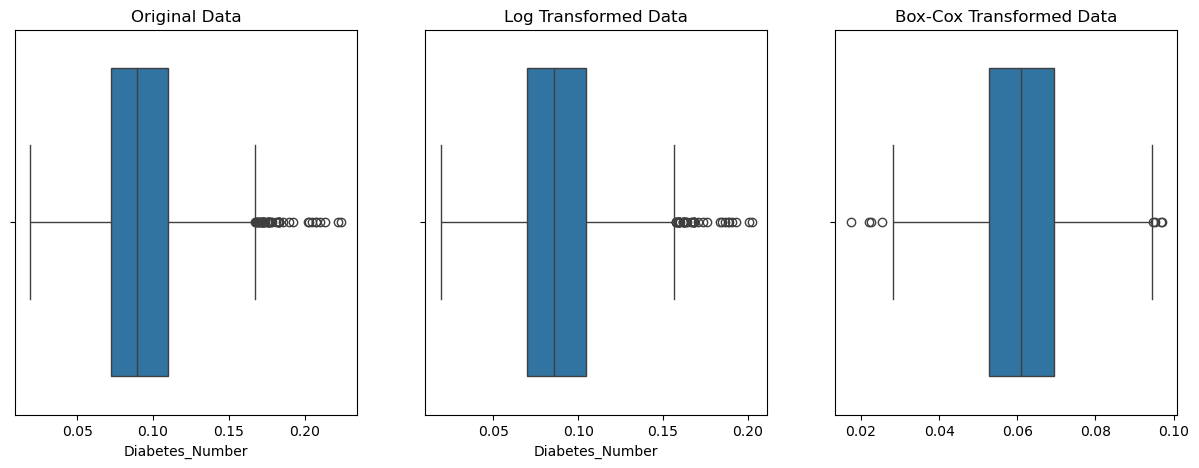

In [403]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import root_mean_squared_error


log_transformed = np.log1p(y)
boxcox_transformed, _ = boxcox(y + 1) 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x = y)
plt.title("Original Data")

plt.subplot(1, 3, 2)
sns.boxplot(x=log_transformed)
plt.title("Log Transformed Data")

plt.subplot(1, 3, 3)
sns.boxplot(x=boxcox_transformed)
plt.title("Box-Cox Transformed Data")

plt.show()

In [414]:
y_train_log = np.log1p(y_train) 
param_grid = {
    'alpha': np.logspace(-2, 3, 20),
    'l1_ratio': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
}

elastic_net = ElasticNet(max_iter=10000)
elastic_grid = GridSearchCV(elastic_net, param_grid, cv=5)
elastic_grid.fit(X_train_reduced, y_train_log)

y_validate_pred_log = elastic_grid.best_estimator_.predict(X_validate_reduced)
y_validate_pred_original = np.expm1(y_validate_pred_log) 

best_params = elastic_grid.best_params_
print("Updated best parameters:", best_params)

rmse = root_mean_squared_error(y_validate, y_validate_pred_original)  
r2 = r2_score(y_validate, y_validate_pred_original)
print(f"Validation RMSE with Log Transform: {rmse}")
print(f"Validation R^2 with Log Transform: {r2}")

y_test_pred_log = elastic_grid.best_estimator_.predict(X_test_reduced)
y_test_pred_original = np.expm1(y_test_pred_log)
rmse = root_mean_squared_error(y_test, y_test_pred_original)  
r2 = r2_score(y_test, y_test_pred_original)
print(f"Validation RMSE with Log Transform: {rmse}")
print(f"Validation R^2 with Log Transform: {r2}")

Updated best parameters: {'alpha': 0.11288378916846889, 'l1_ratio': 0.0001}
Validation RMSE with Log Transform: 0.019118678431897424
Validation R^2 with Log Transform: 0.4603537992400517
Validation RMSE with Log Transform: 0.02024950124033912
Validation R^2 with Log Transform: 0.4601943096499487


In [416]:
y_train_bc, lambda_bc = boxcox(y_train)

param_grid = {
    'alpha': np.logspace(-2, 3, 20),
    'l1_ratio': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1] }

elastic_net = ElasticNet(max_iter=10000)
elastic_grid = GridSearchCV(elastic_net, param_grid, cv=5)
elastic_grid.fit(X_train_reduced, y_train_bc)

y_validate_pred_bc = elastic_grid.best_estimator_.predict(X_validate_reduced)
y_validate_pred_original = inv_boxcox(y_validate_pred_bc, lambda_bc)

best_params = elastic_grid.best_params_
print("Updated best parameters:", best_params)

rmse = root_mean_squared_error(y_validate, y_validate_pred_original)
r2 = r2_score(y_validate, y_validate_pred_original)
print(f"Validation RMSE with Box-Cox: {rmse}")
print(f"Validation R^2 with Box-Cox: {r2}")

y_test_pred_bc = elastic_grid.best_estimator_.predict(X_test_reduced)
y_test_pred_original = inv_boxcox(y_test_pred_bc, lambda_bc)
rmse = root_mean_squared_error(y_test, y_test_pred_original)  
r2 = r2_score(y_test, y_test_pred_original)
print(f"Test RMSE with Log Transform: {rmse}")
print(f"Test R^2 with Log Transform: {r2}")

Updated best parameters: {'alpha': 0.11288378916846889, 'l1_ratio': 0.001}
Validation RMSE with Box-Cox: 0.019129738940545316
Validation R^2 with Box-Cox: 0.4597292280375014
Test RMSE with Log Transform: 0.020275290498606373
Test R^2 with Log Transform: 0.45881846803924664


The model’s generalization performance not significantly improve after processing outliers, which suggests that the model is either robust enough to handle outliers (by regularization) or that the outliers are not strongly correlated with the target.